# **EfficientNet**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
import os
import sys

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
PROJECT_DIR = os.path.basename(project_root)

In [4]:
from src.model import EfficientNetDF
from src.utils import * 

In [5]:
DATA_ROOT = '../data/images'
RESULTS_DIR = '../results/efficient-net'
MODELS_DIR = '../model_checkpoints'

In [6]:
MODEL_NAME = 'efficientnet'

In [7]:
DEVICE = torch.device(get_device())
torch.backends.cudnn.benchmark = True
set_seed(42)

In [8]:
print(f"Project Root: {PROJECT_DIR}")
print(f"Device: {DEVICE}")

Project Root: deep_fake_detection
Device: cuda


## **Without Augmentation**

In [9]:
TASK_NAME = 'deepfake_detection'

In [10]:
from torchvision import transforms as tvtf

transform = tvtf.Compose([
    tvtf.Resize((224, 224)),
    tvtf.ToTensor(),
    tvtf.Normalize(
        mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225]
    )
])

In [11]:
def org_dataloaders(root_dir, transform, batch_size=32):
    from torchvision import datasets
    from torch.utils.data import DataLoader
    
    def flip_label(y):
        return 1 - y
    
    # Define path
    train_dir = os.path.join(root_dir, 'train')
    valid_dir = os.path.join(root_dir, 'val')
    
    
    # Create Dataset with ImageFolder
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform, target_transform=flip_label)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform, target_transform=flip_label)
    
    print(f"Classes found: {train_dataset.class_to_idx}")
    print("APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.")
    
    # Loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True)
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True)
    
    return train_loader, valid_loader

In [12]:
BATCH_SIZE = 32

EPOCHS_STAGE_1 = 15
LR_STAGE_1 = 0.001

EPOCHS_STAGE_2 = 15
LR_STAGE_2 = 0.0001

In [13]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "EPOCHS": EPOCHS_STAGE_1 + EPOCHS_STAGE_2,
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": ""
}

best_acc = 0.0

In [14]:
train_loader, valid_loader = org_dataloaders(DATA_ROOT, transform, BATCH_SIZE)

print(f"- Train batches: {len(train_loader)}")
print(f"- Valid batches: {len(valid_loader)}")

Classes found: {'fake': 0, 'real': 1}
APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.
- Train batches: 750
- Valid batches: 125


In [15]:
import torchsummary

model = EfficientNetDF(num_classes=2, pretrained=True).to(DEVICE)
torchsummary.summary(model, (3, 224, 224), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [16]:
# Freeze Backbone for Initial Training
for param in model.model.features.parameters():
    param.requires_grad = False
    
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters (Stage 1):", trainable_params)

Trainable Parameters (Stage 1): 2562


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_1)

In [19]:
for epoch in range(EPOCHS_STAGE_1):
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    history["train_losses"].append(train_loss)
    history["train_accuracy"].append(train_acc)
    history["val_losses"].append(valid_loss)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    print(f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODELS_DIR}/best_{MODEL_NAME}_{TASK_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.10it/s]


[1/15] train_acc: 0.6315 - train_loss: 0.6399 - valid_acc: 0.6655 - valid_loss: 0.6153
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection.pth
	- [current best] epoch: 1 - acc: 0.6655



Evaluating: 100%|██████████| 125/125 [00:35<00:00,  3.54it/s]


[2/15] train_acc: 0.6453 - train_loss: 0.6310 - valid_acc: 0.6610 - valid_loss: 0.6216
	- [current best] epoch: 1 - acc: 0.6655



Evaluating: 100%|██████████| 125/125 [00:35<00:00,  3.51it/s]


[3/15] train_acc: 0.6500 - train_loss: 0.6262 - valid_acc: 0.6730 - valid_loss: 0.6124
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection.pth
	- [current best] epoch: 3 - acc: 0.6730



Evaluating: 100%|██████████| 125/125 [00:31<00:00,  3.95it/s]


[4/15] train_acc: 0.6556 - train_loss: 0.6267 - valid_acc: 0.6667 - valid_loss: 0.6125
	- [current best] epoch: 3 - acc: 0.6730



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.11it/s]


[5/15] train_acc: 0.6499 - train_loss: 0.6285 - valid_acc: 0.6650 - valid_loss: 0.6188
	- [current best] epoch: 3 - acc: 0.6730



Evaluating: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]


[6/15] train_acc: 0.6471 - train_loss: 0.6287 - valid_acc: 0.6705 - valid_loss: 0.6100
	- [current best] epoch: 3 - acc: 0.6730



Evaluating: 100%|██████████| 125/125 [00:27<00:00,  4.49it/s]


[7/15] train_acc: 0.6583 - train_loss: 0.6216 - valid_acc: 0.6615 - valid_loss: 0.6118
	- [current best] epoch: 3 - acc: 0.6730



Evaluating: 100%|██████████| 125/125 [00:26<00:00,  4.66it/s]


[8/15] train_acc: 0.6551 - train_loss: 0.6233 - valid_acc: 0.6647 - valid_loss: 0.6091
	- [current best] epoch: 3 - acc: 0.6730



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.00it/s]


[9/15] train_acc: 0.6538 - train_loss: 0.6260 - valid_acc: 0.6760 - valid_loss: 0.6067
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection.pth
	- [current best] epoch: 9 - acc: 0.6760



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.05it/s]


[10/15] train_acc: 0.6493 - train_loss: 0.6294 - valid_acc: 0.6663 - valid_loss: 0.6022
	- [current best] epoch: 9 - acc: 0.6760



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.01it/s]


[11/15] train_acc: 0.6499 - train_loss: 0.6258 - valid_acc: 0.6690 - valid_loss: 0.6123
	- [current best] epoch: 9 - acc: 0.6760



Evaluating: 100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


[12/15] train_acc: 0.6548 - train_loss: 0.6266 - valid_acc: 0.6665 - valid_loss: 0.6066
	- [current best] epoch: 9 - acc: 0.6760



Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.99it/s]


[13/15] train_acc: 0.6563 - train_loss: 0.6247 - valid_acc: 0.6637 - valid_loss: 0.6129
	- [current best] epoch: 9 - acc: 0.6760



Evaluating: 100%|██████████| 125/125 [00:26<00:00,  4.63it/s]


[14/15] train_acc: 0.6492 - train_loss: 0.6272 - valid_acc: 0.6558 - valid_loss: 0.6151
	- [current best] epoch: 9 - acc: 0.6760



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.03it/s]

[15/15] train_acc: 0.6548 - train_loss: 0.6255 - valid_acc: 0.6845 - valid_loss: 0.5979
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection.pth
	- [current best] epoch: 15 - acc: 0.6845



<Figure size 1200x600 with 0 Axes>

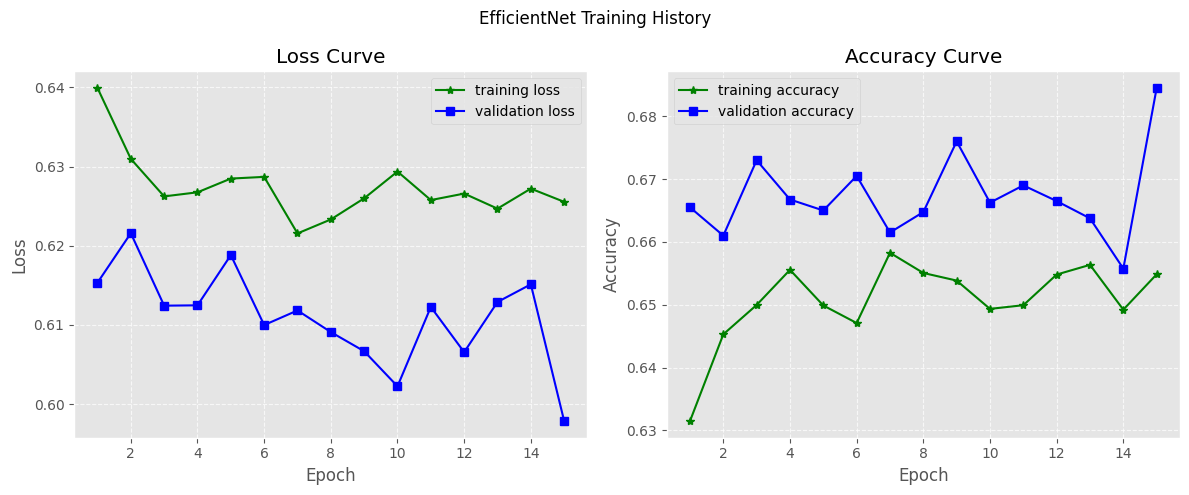

In [26]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("EfficientNet Training History")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend()

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend()

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [27]:
# Unfreeze for Fine-Tuning
for param in model.parameters():
    param.requires_grad = True

In [28]:
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_2)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters (Stage 2): {trainable_params}")

Trainable Parameters (Stage 2): 4010110


In [29]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    history["train_losses"].append(train_loss)
    history["train_accuracy"].append(train_acc)
    history["val_losses"].append(valid_loss)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    print(f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODELS_DIR}/best_{MODEL_NAME}_{TASK_NAME}_finetuned.pth"
        save_checkpoint(model, optimizer, save_name) 
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.65it/s]


[16/30 (Fine-Tune)] train_acc: 0.8787 - train_loss: 0.2844 - valid_acc: 0.8845 - valid_loss: 0.2884
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_finetuned.pth
	- [current best] epoch: 16 - acc: 0.8845



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.81it/s]


[17/30 (Fine-Tune)] train_acc: 0.9346 - train_loss: 0.1622 - valid_acc: 0.8910 - valid_loss: 0.3126
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_finetuned.pth
	- [current best] epoch: 17 - acc: 0.8910



Evaluating: 100%|██████████| 125/125 [00:26<00:00,  4.79it/s]


[18/30 (Fine-Tune)] train_acc: 0.9577 - train_loss: 0.1096 - valid_acc: 0.9117 - valid_loss: 0.2748
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_finetuned.pth
	- [current best] epoch: 18 - acc: 0.9117



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.83it/s]


[19/30 (Fine-Tune)] train_acc: 0.9678 - train_loss: 0.0839 - valid_acc: 0.9095 - valid_loss: 0.3087
	- [current best] epoch: 18 - acc: 0.9117



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.87it/s]


[20/30 (Fine-Tune)] train_acc: 0.9745 - train_loss: 0.0697 - valid_acc: 0.9157 - valid_loss: 0.3023
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_finetuned.pth
	- [current best] epoch: 20 - acc: 0.9157



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.84it/s]


[21/30 (Fine-Tune)] train_acc: 0.9804 - train_loss: 0.0556 - valid_acc: 0.9165 - valid_loss: 0.3096
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_finetuned.pth
	- [current best] epoch: 21 - acc: 0.9165



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.81it/s]


[22/30 (Fine-Tune)] train_acc: 0.9838 - train_loss: 0.0449 - valid_acc: 0.9073 - valid_loss: 0.3559
	- [current best] epoch: 21 - acc: 0.9165



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.07it/s]


[23/30 (Fine-Tune)] train_acc: 0.9837 - train_loss: 0.0412 - valid_acc: 0.9203 - valid_loss: 0.3764
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_finetuned.pth
	- [current best] epoch: 23 - acc: 0.9203



Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.99it/s]


[24/30 (Fine-Tune)] train_acc: 0.9856 - train_loss: 0.0404 - valid_acc: 0.9167 - valid_loss: 0.3521
	- [current best] epoch: 23 - acc: 0.9203



Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.96it/s]


[25/30 (Fine-Tune)] train_acc: 0.9868 - train_loss: 0.0357 - valid_acc: 0.9160 - valid_loss: 0.3463
	- [current best] epoch: 23 - acc: 0.9203



Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.98it/s]


[26/30 (Fine-Tune)] train_acc: 0.9892 - train_loss: 0.0294 - valid_acc: 0.9270 - valid_loss: 0.3467
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_finetuned.pth
	- [current best] epoch: 26 - acc: 0.9270



Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.89it/s]


[27/30 (Fine-Tune)] train_acc: 0.9899 - train_loss: 0.0272 - valid_acc: 0.9055 - valid_loss: 0.4683
	- [current best] epoch: 26 - acc: 0.9270



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.66it/s]


[28/30 (Fine-Tune)] train_acc: 0.9908 - train_loss: 0.0262 - valid_acc: 0.9032 - valid_loss: 0.5537
	- [current best] epoch: 26 - acc: 0.9270



Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.93it/s]


[29/30 (Fine-Tune)] train_acc: 0.9909 - train_loss: 0.0242 - valid_acc: 0.9355 - valid_loss: 0.3515
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_finetuned.pth
	- [current best] epoch: 29 - acc: 0.9355



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.06it/s]

[30/30 (Fine-Tune)] train_acc: 0.9919 - train_loss: 0.0240 - valid_acc: 0.9385 - valid_loss: 0.3388
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_finetuned.pth
	- [current best] epoch: 30 - acc: 0.9385



In [30]:
json_path = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_history.json"
save_experiment_json(history, json_path)

History saved to ../results/efficient-net/efficientnet_deepfake_detection_history.json


<Figure size 1200x600 with 0 Axes>

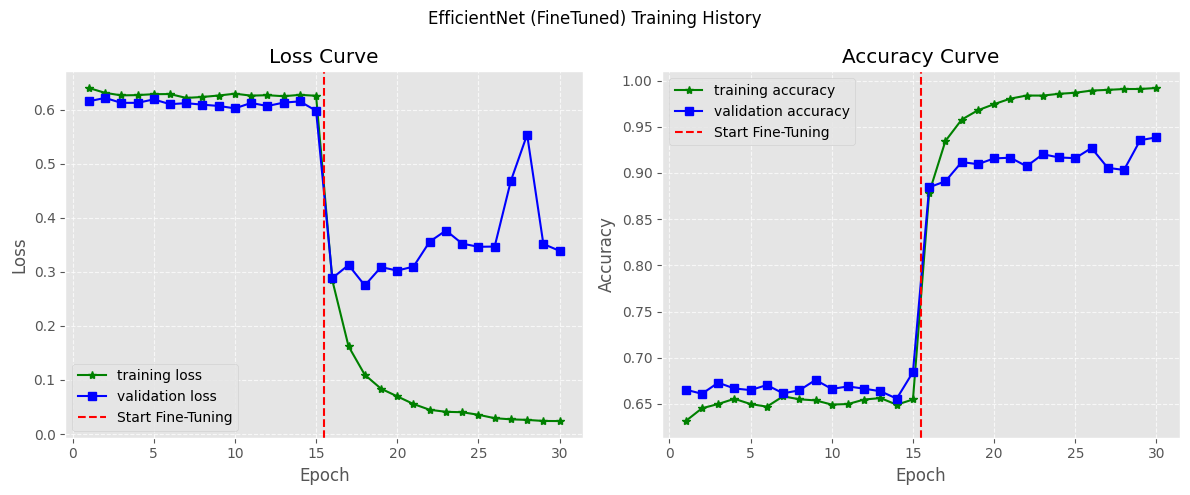

In [31]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("EfficientNet (FineTuned) Training History")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[0].legend()

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[1].legend()

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_finetuned.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

Getting predictions: 100%|██████████| 125/125 [00:23<00:00,  5.36it/s]

Accuracy score: 0.9385
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2000
           1       0.93      0.95      0.94      2000

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



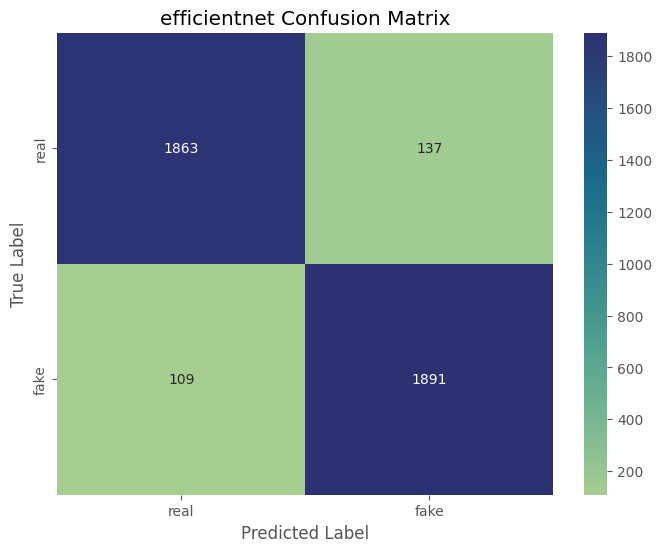

In [33]:
performance(model, valid_loader, DEVICE, MODEL_NAME, TASK_NAME, RESULTS_DIR)

## **With Augmentation**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torchsummary
import torch.nn as nn
import torch.optim as optim

In [3]:
import os
import sys
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
PROJECT_DIR = os.path.basename(project_root)

In [4]:
from src.dataloader import get_data_loaders
from src.model import EfficientNetDF
from src.utils import *

In [5]:
DATA_ROOT = '../data/images'
RESULTS_DIR = '../results/efficient-net'
MODEL_NAME = 'efficientnet'
TASK_NAME = 'deepfake_detection_aug'
MODELS_DIR = '../model_checkpoints'

In [6]:
BATCH_SIZE = 32

# Train Head Only
EPOCHS_STAGE_1 = 10
LR_STAGE_1 = 0.001

# Fine-Tune
EPOCHS_STAGE_2 = 20
LR_STAGE_2 = 0.0001

In [7]:
torch.backends.cudnn.benchmark = True
DEVICE = torch.device(get_device())
BENCHMARK = torch.backends.cudnn.benchmark

In [8]:
print(f"Project path: {PROJECT_DIR}")
print(f"Device: {DEVICE}")
print(f"Benchmark: {BENCHMARK}")

Project path: deep_fake_detection
Device: cuda
Benchmark: True


In [9]:
train_loader, valid_loader = get_data_loaders(DATA_ROOT, "efficientnet", 32)

Class expected: ['real', 'fake']
Label mapping: {'real': 0, 'fake': 1}


In [10]:
model = EfficientNetDF(num_classes=2, pretrained=True).to(DEVICE)
torchsummary.summary(model, (3, 224, 224), BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [11]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "EPOCHS": EPOCHS_STAGE_1 + EPOCHS_STAGE_2,
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": ""
}

best_acc = 0.0

In [12]:
# Freeze Backbone
for param in model.model.features.parameters():
    param.requires_grad = False
    
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters (stage 1): {trainable_params}")

Trainable parameters (stage 1): 2562


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_1)

In [14]:
for epoch in range(EPOCHS_STAGE_1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODELS_DIR}/best_{MODEL_NAME}_{TASK_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.92it/s]


[1/10] train_acc: 0.5707 - train_loss: 0.6828 - valid_acc: 0.6230 - valid_loss: 0.6512
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_aug.pth
	- [current best] epoch: 1 - acc: 0.6230



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.91it/s]


[2/10] train_acc: 0.5846 - train_loss: 0.6757 - valid_acc: 0.6370 - valid_loss: 0.6415
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_aug.pth
	- [current best] epoch: 2 - acc: 0.6370



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.05it/s]


[3/10] train_acc: 0.5939 - train_loss: 0.6732 - valid_acc: 0.6452 - valid_loss: 0.6396
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_aug.pth
	- [current best] epoch: 3 - acc: 0.6452



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.88it/s]


[4/10] train_acc: 0.5908 - train_loss: 0.6722 - valid_acc: 0.6432 - valid_loss: 0.6361
	- [current best] epoch: 3 - acc: 0.6452



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.95it/s]


[5/10] train_acc: 0.5930 - train_loss: 0.6764 - valid_acc: 0.6272 - valid_loss: 0.6446
	- [current best] epoch: 3 - acc: 0.6452



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.01it/s]


[6/10] train_acc: 0.5987 - train_loss: 0.6685 - valid_acc: 0.6345 - valid_loss: 0.6393
	- [current best] epoch: 3 - acc: 0.6452



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.84it/s]


[7/10] train_acc: 0.5909 - train_loss: 0.6728 - valid_acc: 0.6452 - valid_loss: 0.6345
	- [current best] epoch: 3 - acc: 0.6452



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.93it/s]


[8/10] train_acc: 0.5931 - train_loss: 0.6718 - valid_acc: 0.6400 - valid_loss: 0.6419
	- [current best] epoch: 3 - acc: 0.6452



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.82it/s]


[9/10] train_acc: 0.5911 - train_loss: 0.6756 - valid_acc: 0.6542 - valid_loss: 0.6250
Checkpoint saved: ../model_checkpoints/best_efficientnet_deepfake_detection_aug.pth
	- [current best] epoch: 9 - acc: 0.6542



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]


[10/10] train_acc: 0.5946 - train_loss: 0.6734 - valid_acc: 0.6322 - valid_loss: 0.6376
	- [current best] epoch: 9 - acc: 0.6542



<Figure size 1200x600 with 0 Axes>

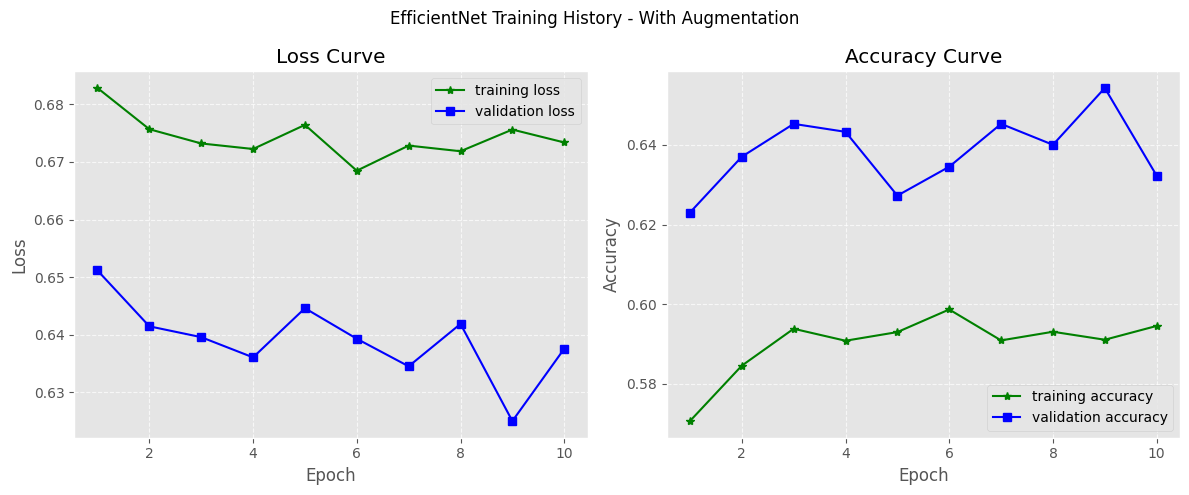

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("EfficientNet Training History - With Augmentation")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend()

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend()

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_aug.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [16]:
# Unfreeze for Fine-Tuning
for param in model.parameters():
    param.requires_grad = True

In [17]:
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_2)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters (Stage 2): {trainable_params}")

Trainable Parameters (Stage 2): 4010110


In [18]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    history["train_losses"].append(train_loss)
    history["train_accuracy"].append(train_acc)
    history["val_losses"].append(valid_loss)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    print(f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODELS_DIR}/{MODEL_NAME}_{TASK_NAME}_finetuned.pth"
        save_checkpoint(model, optimizer, save_name) 
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.08it/s]


[11/30 (Fine-Tune)] train_acc: 0.6842 - train_loss: 0.5804 - valid_acc: 0.8007 - valid_loss: 0.4248
Checkpoint saved: ../model_checkpoints/efficientnet_deepfake_detection_aug_finetuned.pth
	- [current best] epoch: 11 - acc: 0.8007



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


[12/30 (Fine-Tune)] train_acc: 0.7861 - train_loss: 0.4386 - valid_acc: 0.8160 - valid_loss: 0.4213
Checkpoint saved: ../model_checkpoints/efficientnet_deepfake_detection_aug_finetuned.pth
	- [current best] epoch: 12 - acc: 0.8160



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


[13/30 (Fine-Tune)] train_acc: 0.8271 - train_loss: 0.3641 - valid_acc: 0.8638 - valid_loss: 0.3556
Checkpoint saved: ../model_checkpoints/efficientnet_deepfake_detection_aug_finetuned.pth
	- [current best] epoch: 13 - acc: 0.8638



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


[14/30 (Fine-Tune)] train_acc: 0.8560 - train_loss: 0.3175 - valid_acc: 0.8822 - valid_loss: 0.2969
Checkpoint saved: ../model_checkpoints/efficientnet_deepfake_detection_aug_finetuned.pth
	- [current best] epoch: 14 - acc: 0.8822



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]


[15/30 (Fine-Tune)] train_acc: 0.8729 - train_loss: 0.2827 - valid_acc: 0.8970 - valid_loss: 0.2935
Checkpoint saved: ../model_checkpoints/efficientnet_deepfake_detection_aug_finetuned.pth
	- [current best] epoch: 15 - acc: 0.8970



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.02it/s]


[16/30 (Fine-Tune)] train_acc: 0.8858 - train_loss: 0.2626 - valid_acc: 0.9085 - valid_loss: 0.2702
Checkpoint saved: ../model_checkpoints/efficientnet_deepfake_detection_aug_finetuned.pth
	- [current best] epoch: 16 - acc: 0.9085



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.42it/s]


[17/30 (Fine-Tune)] train_acc: 0.8972 - train_loss: 0.2329 - valid_acc: 0.8522 - valid_loss: 0.5022
	- [current best] epoch: 16 - acc: 0.9085



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.46it/s]


[18/30 (Fine-Tune)] train_acc: 0.9051 - train_loss: 0.2228 - valid_acc: 0.8960 - valid_loss: 0.3221
	- [current best] epoch: 16 - acc: 0.9085



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  6.97it/s]


[19/30 (Fine-Tune)] train_acc: 0.9131 - train_loss: 0.2014 - valid_acc: 0.9185 - valid_loss: 0.2325
Checkpoint saved: ../model_checkpoints/efficientnet_deepfake_detection_aug_finetuned.pth
	- [current best] epoch: 19 - acc: 0.9185



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.07it/s]


[20/30 (Fine-Tune)] train_acc: 0.9208 - train_loss: 0.1880 - valid_acc: 0.9070 - valid_loss: 0.2819
	- [current best] epoch: 19 - acc: 0.9185



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[21/30 (Fine-Tune)] train_acc: 0.9264 - train_loss: 0.1754 - valid_acc: 0.9070 - valid_loss: 0.2798
	- [current best] epoch: 19 - acc: 0.9185



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


[22/30 (Fine-Tune)] train_acc: 0.9342 - train_loss: 0.1609 - valid_acc: 0.9125 - valid_loss: 0.3125
	- [current best] epoch: 19 - acc: 0.9185



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.51it/s]


[23/30 (Fine-Tune)] train_acc: 0.9353 - train_loss: 0.1594 - valid_acc: 0.8480 - valid_loss: 0.6019
	- [current best] epoch: 19 - acc: 0.9185



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]


[24/30 (Fine-Tune)] train_acc: 0.9382 - train_loss: 0.1485 - valid_acc: 0.9297 - valid_loss: 0.2650
Checkpoint saved: ../model_checkpoints/efficientnet_deepfake_detection_aug_finetuned.pth
	- [current best] epoch: 24 - acc: 0.9297



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]


[25/30 (Fine-Tune)] train_acc: 0.9443 - train_loss: 0.1389 - valid_acc: 0.9283 - valid_loss: 0.2501
	- [current best] epoch: 24 - acc: 0.9297



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


[26/30 (Fine-Tune)] train_acc: 0.9454 - train_loss: 0.1336 - valid_acc: 0.9067 - valid_loss: 0.3015
	- [current best] epoch: 24 - acc: 0.9297



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


[27/30 (Fine-Tune)] train_acc: 0.9463 - train_loss: 0.1294 - valid_acc: 0.9030 - valid_loss: 0.3252
	- [current best] epoch: 24 - acc: 0.9297



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.43it/s]


[28/30 (Fine-Tune)] train_acc: 0.9484 - train_loss: 0.1226 - valid_acc: 0.9170 - valid_loss: 0.3377
	- [current best] epoch: 24 - acc: 0.9297



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


[29/30 (Fine-Tune)] train_acc: 0.9532 - train_loss: 0.1167 - valid_acc: 0.8940 - valid_loss: 0.3921
	- [current best] epoch: 24 - acc: 0.9297



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.27it/s]

[30/30 (Fine-Tune)] train_acc: 0.9536 - train_loss: 0.1155 - valid_acc: 0.8685 - valid_loss: 0.5293
	- [current best] epoch: 24 - acc: 0.9297



<Figure size 1200x600 with 0 Axes>

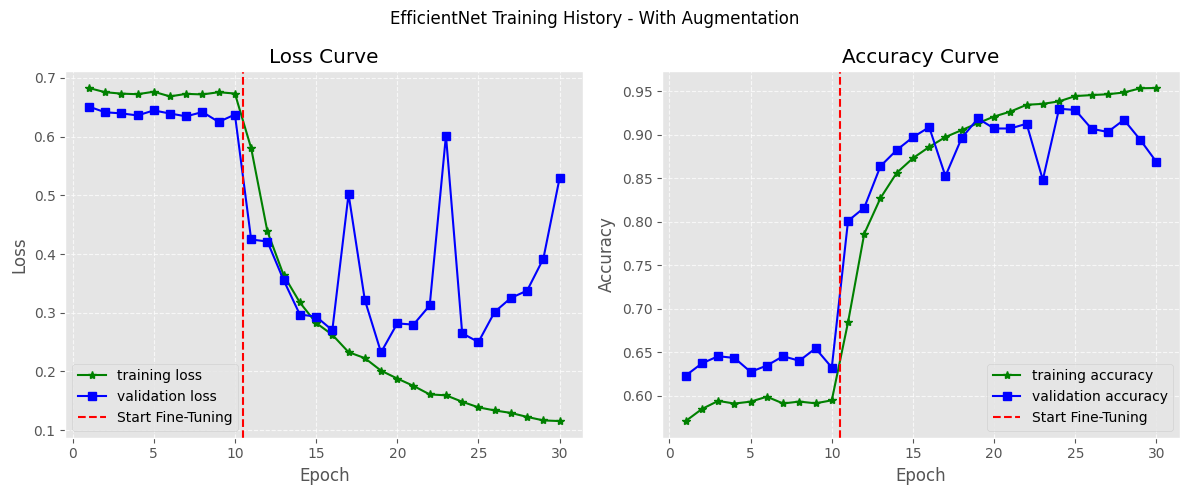

In [19]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("EfficientNet Training History - With Augmentation")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[0].legend()

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[1].legend()

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_finetuned.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [22]:
json_filename = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history, json_filename)

History saved to ../results/efficient-net/efficientnet_deepfake_detection_aug.json


Getting predictions: 100%|██████████| 125/125 [00:19<00:00,  6.29it/s]


- Accuracy score: 0.8685
- Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      2000
           1       0.80      0.97      0.88      2000

    accuracy                           0.87      4000
   macro avg       0.89      0.87      0.87      4000
weighted avg       0.89      0.87      0.87      4000



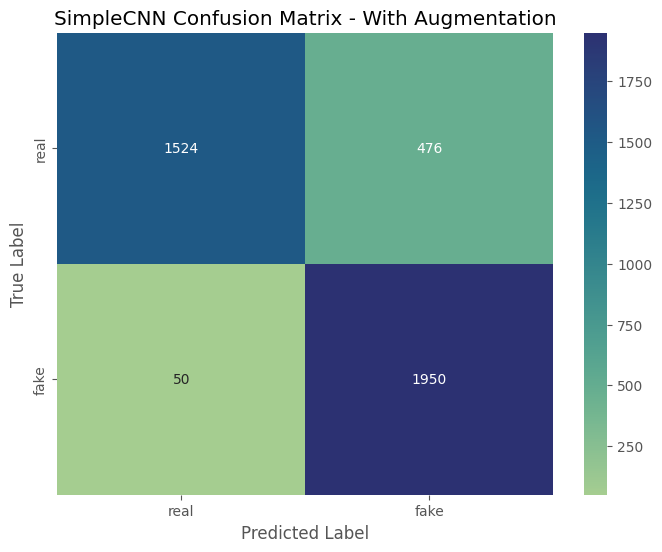

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true, y_pred = get_all_predictions(model, valid_loader, DEVICE)
class_names = ['real', 'fake']
    
acc = accuracy_score(y_true, y_pred)
print(f"- Accuracy score: {acc:.4f}")

print(f"- Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='crest',
    xticklabels=class_names,
    yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'SimpleCNN Confusion Matrix - With Augmentation')
img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_cfm.png"
plt.savefig(img_save)
plt.show()